# FIT3182 - Assignment 2
---
## Part B - Data Visualisation

- Filename: Assignment_PartB_Data_Visualisation.ipynb
- Student Name: Deeksha Sridhar
- Student ID: 32187998

---

### Task 2

**Q1:** 

For the incoming climate data plot the line graph of air temperature against arrival time. You need to label some interesting points such as maximum and minimum values.

<IPython.core.display.Javascript object>


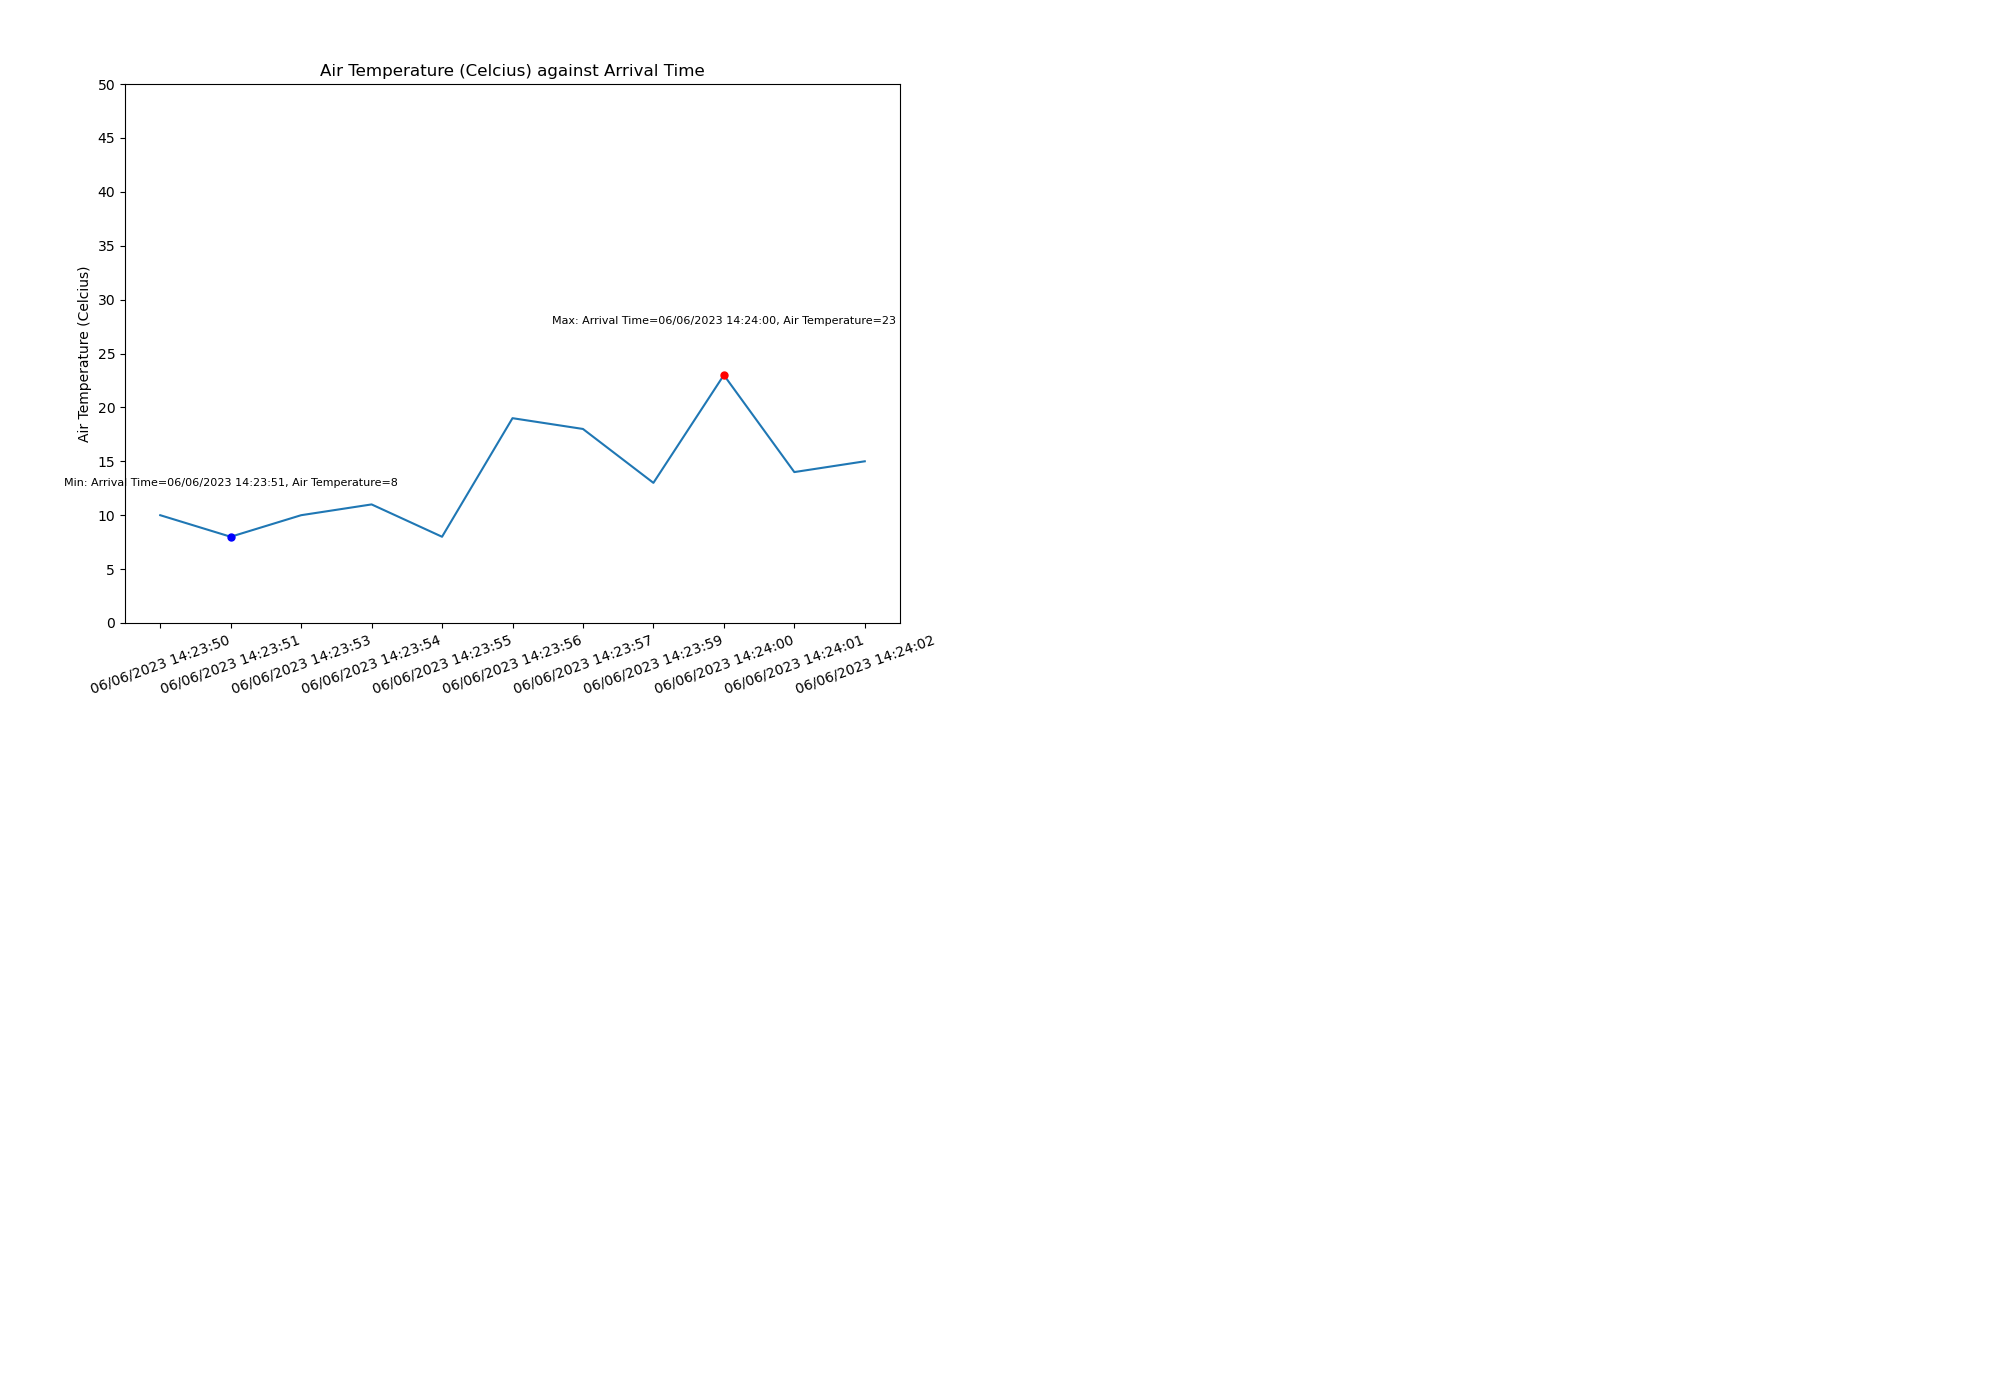

In [ ]:
from kafka3 import KafkaConsumer
from datetime import datetime
from json import loads
import statistics
import matplotlib.pyplot as plt
from time import sleep

%matplotlib notebook

topic = 'streaming'

def marker_max(x, y, ax=None):
    """
    Annotates the maximum value in the plot.

    Args:
        x (list): List of x-values.
        y (list): List of y-values.
        ax (matplotlib.axes.Axes, optional): The Axes object to annotate on. Defaults to None.

    Returns:
        None
    """
    ymax = max(y)
    xpos = y.index(ymax)
    xmax = x[xpos]
    text = 'Max: Arrival Time={}, Air Temperature={}'.format(xmax, ymax)
    if not ax:
        ax = plt.gca()
    ax.annotate(text, xy=(xmax, ymax), xytext=(xmax, ymax + 5),
                arrowprops=dict(facecolor='none', edgecolor='none'),
                ha='center', va='center', fontsize=8)
    ax.plot(xmax, ymax, marker='o', markersize=5, color='red')


def marker_min(x, y, ax=None):
    """
    Annotates the minimum value in the plot.

    Args:
        x (list): List of x-values.
        y (list): List of y-values.
        ax (matplotlib.axes.Axes, optional): The Axes object to annotate on. Defaults to None.

    Returns:
        None
    """
    ymin = min(y)
    xpos = y.index(ymin)
    xmin = x[xpos]
    text = 'Min: Arrival Time={}, Air Temperature={}'.format(xmin, ymin)
    if not ax:
        ax = plt.gca()
    ax.annotate(text, xy=(xmin, ymin), xytext=(xmin, ymin + 5),
                arrowprops=dict(facecolor='none', edgecolor='none'),
                ha='center', va='center', fontsize=8)
    ax.plot(xmin, ymin, marker='o', markersize=5, color='blue')


def connect_kafka_consumer():
    """
    Connects to the Kafka consumer.

    Returns:
        KafkaConsumer: The Kafka consumer object.
    """
    consumer = None
    try:
        consumer = KafkaConsumer(
            topic,
            auto_offset_reset='earliest', 
            bootstrap_servers=['192.168.86.244:9092'],
            value_deserializer=lambda x: loads(x.decode('ascii')),
            api_version=(0, 10)
        )
    except Exception as ex:
        print('Exception while connecting to Kafka')
        print(str(ex))
    finally:
        return consumer


def init_plots():
    """
    Initializes the plot figure and axes.

    Returns:
        tuple: A tuple containing the figure and axes objects.
    """
    try:
        width = 10
        height = 7
        fig = plt.figure(figsize=(width, height))
        fig.subplots_adjust(hspace=0.5)
        ax1 = fig.add_subplot(111)
        ax1.set_xlabel('Arrival Time')
        ax1.set_ylabel('Air Temperature')
        fig.show()  
        fig.canvas.draw()  
        return fig, ax1
    except Exception as ex:
        print(str(ex))


def consume_messages(consumer, fig, ax1):
    """
    Consume messages from Kafka and plot the air temperature data.

    Args:
        consumer (KafkaConsumer): The Kafka consumer object.
        fig (matplotlib.figure.Figure): The plot figure object.
        ax1 (matplotlib.axes.Axes): The plot axes object.

    Returns:
        None
    """
    try:
        # Storing x and y values
        x_values, y_values = [], []

        for message in consumer:
            message = message.value

            if message['producer'] == 'climate_streaming':
                x_values.append(datetime.now().strftime('%d/%m/%Y %H:%M:%S'))  
                y_values.append(message['air_temperature_celcius'])
                sleep(1)  

            if len(y_values) > 10:
                ax1.clear()
                ax1.plot(x_values, y_values)
                ax1.set_title('Air Temperature (Celcius) against Arrival Time')
                ax1.set_xlabel('Arrival Time')
                ax1.set_ylabel('Air Temperature (Celcius)')
                ax1.set_ylim(0, 50)
                ax1.set_yticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
                ax1.tick_params(axis='x', labelrotation=20)

                # add a marker for the maximum value
                marker_max(x_values, y_values, ax1)
                
                # add a marker for the minimum value
                marker_min(x_values, y_values, ax1)  

                fig.canvas.draw()
                x_values.pop(0) 
                y_values.pop(0)

        plt.close('all')
    except Exception as ex:
        print(str(ex))


if __name__ == '__main__':
    consumer = connect_kafka_consumer()
    fig, ax1 = init_plots()
    consume_messages(consumer, fig, ax1)


---

**Q2:** 

A. Plot a bar chat to visualise the total number of fire records based on each hour.

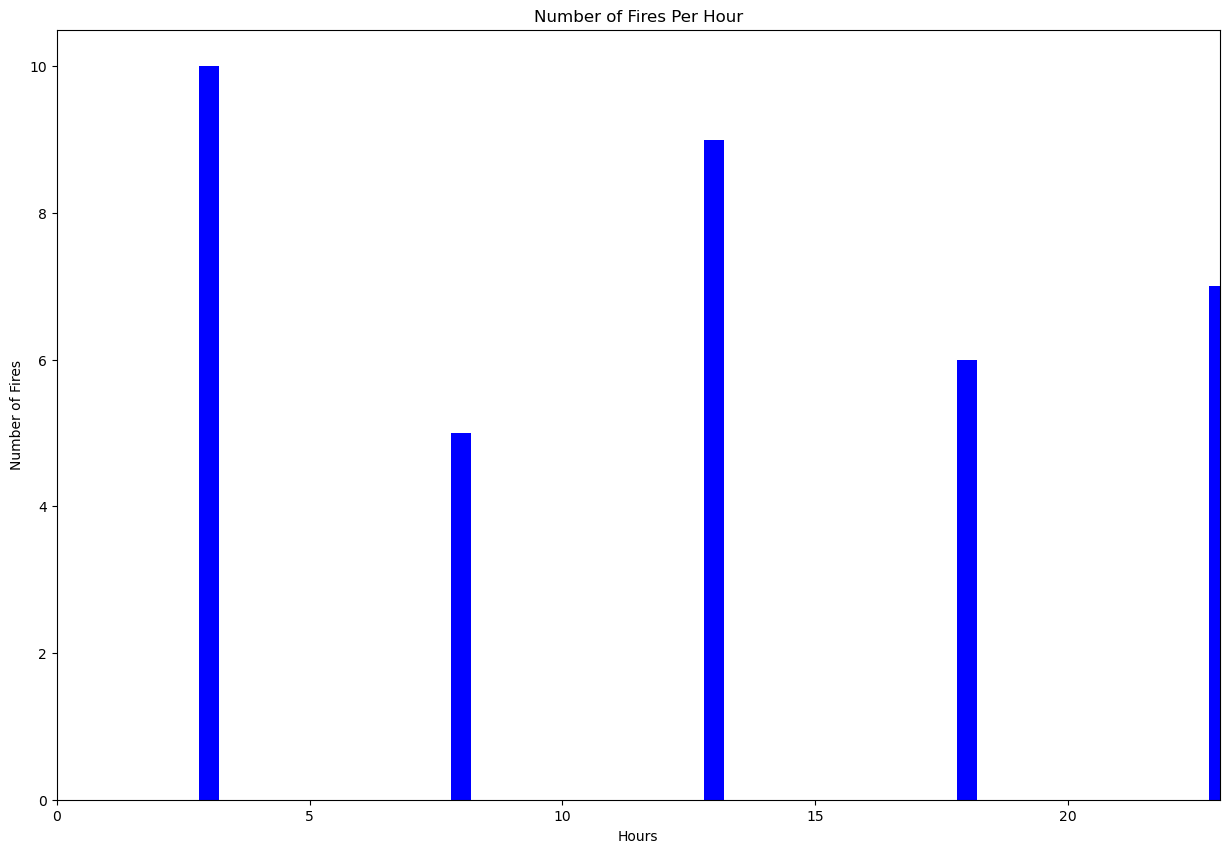

In [11]:
import matplotlib.pyplot as plt
from pymongo import MongoClient

def plot_number_of_fires_per_hour(host, port, database, collection_name):
    """
    Fetches data from MongoDB and plots the number of fires per hour.

    Args:
        host (str): MongoDB server hostname or IP address.
        port (int): MongoDB server port number.
        database (str): Name of the database.
        collection_name (str): Name of the collection.

    Returns:
        None
    """
    # Connect to MongoDB
    client = MongoClient(f"mongodb://{host}:{port}/")
    db = client[database]
    collection = db[collection_name]

    # Aggregate the data to get the number of fires per hour
    pipeline = [
        {"$unwind": "$hotspots"},
        {"$project": {
            "_id": 0,
            "hour": {"$hour": {"$dateFromString": {"dateString": "$hotspots.datetime", "format": "%d/%m/%Y %H:%M:%S"}}}
        }},
        {"$group": {
            "_id": "$hour",
            "numberOfFire": {"$sum": 1}
        }},
        {"$sort": {"_id": 1}}
    ]
    cursor = collection.aggregate(pipeline)

    # Extract the hour and number of fires from the cursor
    hour = []
    numberOfFire = []
    for document in cursor:
        hour.append(document['_id'])
        numberOfFire.append(document['numberOfFire'])

    # Plot the number of fires per hour
    fig = plt.figure(figsize=(15, 10))
    plt.bar(hour, numberOfFire, color='blue', width=0.4)
    plt.xlabel("Hours")
    plt.ylabel("Number of Fires")
    plt.title("Number of Fires Per Hour")
    plt.xlim(0, 23)  # Set x-axis limits
    plt.show()

# Example usage
host = '192.168.86.244'
port = 27017
database = 'fit3182_assignment_db'
collection_name = 'streaming'
plot_number_of_fires_per_hour(host, port, database, collection_name)


B. In a map visualise fire locations are makers. Use a 'blue' marker if the cause of the fire was 'natural'. Otherwise, use a 'red' marker. Display detailed information such as air temperature, surface temperature, relative humidity, and confidence with marker tooltips.

In [10]:
from pprint import pprint
from pymongo import MongoClient
import folium

def create_fire_map():
    """
    Creates a map with markers representing fire occurrences.
    """
    # Create a map based on Victoria's location
    victoria_location = [-36.9848, 143.3906]
    fire_map = folium.Map(location=victoria_location, zoom_start=6)

    # Connect to the database collection
    client = MongoClient('mongodb://192.168.86.244:27017/')
    db = client.fit3182_assignment_db
    collection = db.streaming

    # Get all fire occurrences from the collection
    cursor = collection.aggregate([
        {"$unwind": "$hotspots"}
    ])

    for document in cursor:
        # Get the necessary detailed information
        location = (document['hotspots']['latitude'], document['hotspots']['longitude'])
        air_temp = document['air_temperature_celcius']
        surface_temp = document['hotspots']['surface_temperature_celcius']
        relative_humidity = document['relative_humidity']
        confidence = document['hotspots']['confidence']
        fire_cause = document['hotspots']['cause']

        # Prepare the popup detailed information
        detailed_information = f"""
        <ul>
            <li><b>Cause:</b> {fire_cause}</li>
            <li><b>Air Temp:</b> {air_temp}</li>
            <li><b>Surface Temp:</b> {surface_temp}</li>
            <li><b>Relative Humidity:</b> {relative_humidity}</li>
            <li><b>Confidence:</b> {confidence}</li>
        </ul>
        """

        # Add marker according to fire cause
        if fire_cause == 'natural':
            folium.Marker(location=location, 
                          popup=folium.Popup(html=detailed_information, max_width=130),
                          icon=folium.Icon(color="blue", icon="info-sign")).add_to(fire_map)
        elif fire_cause == 'other':
            folium.Marker(location=location, 
                          popup=folium.Popup(html=detailed_information, max_width=130),
                          icon=folium.Icon(color="red", icon="info-sign")).add_to(fire_map)

    # Display the map with the markers
    return fire_map


# Call the function to create the fire map
fire_map = create_fire_map()

# Display the map with the markers
fire_map
